### Supercharge BERT Inference with AWS Inferentia2 and Hugging Face Transformers

In this end-to-end tutorial, we will learn how to speed up BERT inference for text classification with Hugging Face Transformers, Amazon SageMaker, and AWS Inferentia2.

We will learn how to:

1. Convert your Hugging Face Transformer to AWS Neuron (Inferentia2)
2. Create a custom `inference.py` script for `text-classification`
3. Create and upload the neuron model and inference script to Amazon S3
4. Deploy a Real-time Inference Endpoint on Amazon SageMaker
5. Run and evaluate Inference performance of BERT on Inferentia2
6. Clean Up

Let's get started! 🚀

#### 1. Convert your Hugging Face Transformer to AWS Neuron

Need to create an EC2 instance using the following parameters.
- `Instance type = ml.inf2.xlarge` has single inf2 accelerator with 4 CPU cores.
- `AMI = HuggingFace DL AMI(Ubuntu 20.04)` which makes it easy to use Amazon EC2 Inferentia & Trainium instances for efficient training and inference of Hugging Face Transformers and Diffusers models.

Then we can leverage the HuggingFace Optimum Neuron to export a model to Neuron using the export function.
We first need to install some extra dependencies:
`pip install optimum[neuronx]`

In [17]:
model_path = 'model/'
code_path = 'code/'

In [ ]:
import torch
import os
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from optimum.exporters.neuron import export
from optimum.exporters.neuron.model_configs import DistilBertNeuronConfig

model_id = "distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)
neuron_config = DistilBertNeuronConfig(
    config=model.config, task="text-classification", batch_size=1, sequence_length=128,
)

# save tokenizer, neuron model and config for later use
save_dir = "test_bert"

# export to Neuron model
export(
    model=model,
    config=neuron_config,
    output=(os.path.join(save_dir,"model.neuron")),
    auto_cast="none",
    auto_cast_type="tf32",
)

tokenizer.save_pretrained(save_dir)
model.config.save_pretrained(save_dir)

We can use either SageMaker notebook instance or SageMaker Studio to deploy the Neuron model on a Real-time endpoint.

Then can download the neuron model and tokenizer config files from the above step and store them in the model directory, e.g `model/`

In [23]:
model_id = "distilbert-base-uncased-finetuned-sst-2-english"

#### 2. Create a custom `inference.py` script for `text-classification`

We need to create an `inference.py` script by overwriting the `model_fn` to load our neuron model and the `predict_fn` to create a text-classification pipeline.

In [70]:
!mkdir {model_path}/code

We are using the NEURON_RT_NUM_CORES=1 to make sure that each HTTP worker uses 1 Neuron core to maximize throughput.

In [71]:
%%writefile code/inference.py

import os
import json
import torch
from transformers import AutoConfig, AutoTokenizer

# To use one neuron core per worker
os.environ["NEURON_RT_NUM_CORES"] = "1"

def model_fn(model_dir):
    """
    Load the model for inference
    """   
    # Load tokenizer and neuron model from model_dir
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    neuron_model = torch.jit.load(os.path.join(model_dir, "model.neuron"))
    model_config = AutoConfig.from_pretrained(model_dir)
    model_dict = {'neuron_model': neuron_model, 'tokenizer': tokenizer, 'model_config': model_config}
    
    return model_dict

def predict_fn(input_data, model):
    """Apply model to the incoming request.
    
    Documents 
    """
    tokenizer = model['tokenizer']
    neuron_model = model['neuron_model']
    model_config = model['model_config']

    sequence = input_data["sequence"]

    embeddings = tokenizer(
        sequence,
        return_tensors="pt",
        max_length=128,
        padding="max_length",
        truncation=True,
    )
    
    # convert to tuple for neuron model
    neuron_inputs = tuple(embeddings.values())
    
    # run prediciton
    with torch.no_grad():
        predictions = neuron_model(*neuron_inputs)[0]
        scores = torch.nn.Softmax(dim=1)(predictions)

    # return dictonary, which will be json serializable
    return [{"label": model_config.id2label[item.argmax().item()], "score": item.max().item()} for item in scores]

Overwriting code/inference.py


#### 3. Create and upload the neuron model and inference script to Amazon S3

For hosting, SageMaker requires that the deployment package be structured in a compatible format. It expects all files to be packaged in a tar archive named `model.tar.gz` with gzip compression.

We need to create a `model.tar.gz` archive with all our model artifacts saved into `model/`, e.g. `model.neuron` and upload this to Amazon S3.

In [ ]:
import sagemaker
from sagemaker import get_execution_role
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()
    
try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)
sm_client = boto3.client("sagemaker")

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

Next, we create our `model.tar.gz`. The inference.py script will be placed into a `code/` folder.

In [42]:
# copy inference.py into the code/ directory of the model directory.
!cp code/inference.py {model_path}/code/inference.py

# create a model.tar.gz archive with all the model artifacts and the inference.py script.
!tar -czvf {model_path}/model.tar.gz -C {model_path}/ .

./
./tokenizer_config.json
./.ipynb_checkpoints/
./model.neuron
./config.json
./special_tokens_map.json
./vocab.txt
./model.tar.gz
tar: ./model.tar.gz: file changed as we read it
./tokenizer.json
./code/
./code/.ipynb_checkpoints/
./code/.ipynb_checkpoints/inference-checkpoint.py
./code/inference.py
tar: .: file changed as we read it


Now we can upload our model.tar.gz to our session S3 bucket with sagemaker.

In [ ]:
from sagemaker.s3 import S3Uploader

# create s3 uri
s3_model_path = f"s3://{sess.default_bucket()}/{model_id}"

# upload model.tar.gz
s3_model_uri = S3Uploader.upload(local_path="model/model.tar.gz",desired_s3_uri=s3_model_path)
print(f"model artifcats uploaded to {s3_model_uri}")

#### 4. Deploy a Real-time Inference Endpoint on Amazon SageMaker

After we upload model.tar.gz to S3, we can deploy our endpoint. We will use boto3 API to create and deploy our real-time inference endpoint on Amazon SageMaker.

In [ ]:
# Create/Register a BERT model in SM
image_uri = "763104351884.dkr.ecr.us-east-2.amazonaws.com/huggingface-pytorch-inference-neuronx:1.13.0-transformers4.28.1-neuronx-py38-sdk2.9.1-ubuntu20.04"
deployment_name = "text-classification"

primary_container = {
    'Image': image_uri,
    'ModelDataUrl': s3_model_uri,
    'Environment': {
        'SAGEMAKER_PROGRAM': 'inference.py',
        'SAGEMAKER_REGION': sess.boto_region_name,
        'SAGEMAKER_SUBMIT_DIRECTORY': s3_model_uri,
        'SAGEMAKER_MODEL_SERVER_WORKERS': '2'
    }
}

create_model_response = sm_client.create_model(ModelName = f"{deployment_name}-model",
                                              ExecutionRoleArn = get_execution_role(),
                                              PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

# create SageMaker Endpoint configuration
endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = f"{deployment_name}-epc",
    ProductionVariants=[
        {
        'InstanceType':'ml.inf2.xlarge',
        'InitialInstanceCount':1,
        'ModelName': f"{deployment_name}-model",
        'VariantName':'AllTraffic',
        'InitialVariantWeight':1
        }
    ])

print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

# create SageMaker Endpoint
endpoint_params = {
    'EndpointName': f"{deployment_name}-ep", 'EndpointConfigName': f"{deployment_name}-epc"}
endpoint_response = sm_client.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

#### 5. Run and evaluate Inference performance of BERT on Inferentia2

Now that our API endpoint is deployed, we can send it text to get predictions from our BERT model. We can use the SageMaker Runtime API to invoke the endpoint.

In [ ]:
import boto3
import json

sm = boto3.client('sagemaker-runtime')
endpoint_name = f"{deployment_name}-ep"
payload = {"sequence": "Hello, my cats are cute."}
payload = json.dumps(payload)

response = sm.invoke_endpoint(EndpointName=endpoint_name, 
                              Body=payload,
                              ContentType='application/json')

result = json.loads(response['Body'].read())
print("response:", result)

response: [{'label': 'POSITIVE', 'score': 0.9998264908790588}]

We managed to deploy our neuron-compiled BERT to AWS Inferentia2 on Amazon SageMaker. Now, let's test its performance of it. As a dummy load test will we loop and send 10000 synchronous requests to our endpoint.

In [49]:
# send 10000 requests
for i in range(10000):
    response = sm.invoke_endpoint(EndpointName=endpoint_name, 
                                Body=payload,
                                ContentType='application/json')

Let's inspect the performance in Cloudwatch and we can see that the average latency for our BERT model is 2-3ms for a sequence length of 128.

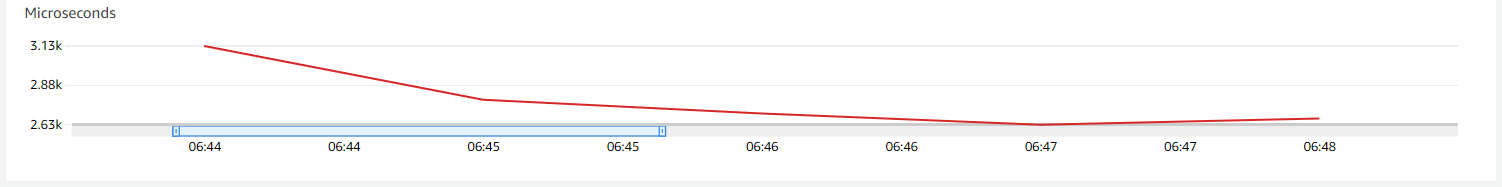

#### Clean Up

To clean up, we can delete the model and endpoint.

In [ ]:
sm_client.delete_model(ModelName=f"{deployment_name}-model")
sm_client.delete_endpoint_config(EndpointConfigName=f"{deployment_name}-epc")
sm_client.delete_endpoint(EndpointName=f"{deployment_name}-ep")